# 07. Regression (Supervised) for PM2.5 (Tabular Time-Lag Features)
Mục tiêu:
- Biến bài toán chuỗi thời gian thành bài toán **hồi quy có giám sát**: dự đoán PM2.5(t+h) từ đặc trưng tại thời điểm t.
- Thấy rõ: **leakage** và vì sao phải split theo thời gian.
- So sánh tư duy hồi quy (feature-based) vs ARIMA (time-series-based).


In [1]:
from pathlib import Path
import sys

# ===== PARAMETERS =====
USE_UCIMLREPO = False

# Path to the raw ZIP (relative to project root)
RAW_ZIP_PATH_REL = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

# Tự động tìm PROJECT_ROOT (thư mục chứa src/)
cwd = Path.cwd().resolve()
PROJECT_ROOT = cwd
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise FileNotFoundError("Không tìm thấy thư mục 'src' trong cây thư mục hiện tại.")

# Bảo đảm import được package trong src
sys.path.insert(0, str(PROJECT_ROOT))

# Chuẩn hoá đường dẫn tuyệt đối
RAW_ZIP_PATH = (PROJECT_ROOT / RAW_ZIP_PATH_REL).resolve()
RAW_ZIP_ABS = str(RAW_ZIP_PATH)

LAG_HOURS = [1, 3, 24]
HORIZON = 1              # dự đoán trước bao nhiêu giờ
TARGET_COL = 'PM2.5'

OUTPUT_REG_DATASET_PATH = 'data/processed/07_dataset_for_regression.parquet'
CUTOFF = '2017-01-01'

MODEL_OUT = '07_regressor.joblib'
METRICS_OUT = '07_regression_metrics.json'
PRED_SAMPLE_OUT = '07_regression_predictions_sample.csv'

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"RAW_ZIP_PATH: {RAW_ZIP_PATH}")

PROJECT_ROOT: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard
RAW_ZIP_PATH: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\raw\PRSA2017_Data_20130301-20170228.zip


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from src.classification_library import Paths
from src import regression_library

# Reload module để áp dụng thay đổi mới nhất
importlib.reload(regression_library)

from src.regression_library import (
    run_prepare_regression_dataset,
    run_train_regression,
)

paths = Paths(project_root=PROJECT_ROOT)

# Tạo thư mục images để lưu biểu đồ
IMAGES_PATH = PROJECT_ROOT / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Tạo thư mục data/processed để lưu CSV
DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
DATA_PATH.mkdir(parents=True, exist_ok=True)

print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)

PROJECT_ROOT = E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard
RAW_ZIP_ABS = E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Tạo dataset hồi quy (lag features + time features + y = PM2.5(t+h))
Trong lab, phần này giúp sinh viên hiểu cách tạo supervised dataset từ time series.

In [3]:

print(f"file_name: ", OUTPUT_REG_DATASET_PATH.split("/")[-1])

file_name:  07_dataset_for_regression.parquet


In [4]:
out_path = run_prepare_regression_dataset(
    paths=paths,
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=RAW_ZIP_ABS,
    lag_hours=LAG_HOURS,
    horizon=HORIZON,
    target_col=TARGET_COL,
    file_name=str(OUTPUT_REG_DATASET_PATH.split("/")[-1])
)
print('Saved:', out_path)

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\07_dataset_for_regression.parquet


## 2) Quick EDA cho dataset hồi quy
Gợi ý câu hỏi ra quyết định:
- Tỉ lệ missing ở các feature lag? (thường thiếu ở đầu chuỗi)
- PM2.5 có phân phối lệch (skew) không? -> cân nhắc log/clip (tuỳ chọn)
- Có khác biệt theo *giờ trong ngày* / *ngày trong tuần* không? (seasonality)


ds_path: fE:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\07_dataset_for_regression.parquet
(420768, 57)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,y
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\07_regression_dataset_sample.csv


CO_lag24     0.049849
CO_lag3      0.049284
CO_lag1      0.049227
CO           0.049198
O3_lag24     0.032203
O3_lag3      0.031640
O3_lag1      0.031583
O3           0.031554
NO2_lag24    0.029446
NO2_lag3     0.028881
NO2_lag1     0.028823
NO2          0.028795
SO2_lag24    0.022091
SO2_lag3     0.021525
SO2_lag1     0.021468
dtype: float64

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\07_missing_values.csv
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\07_target_distribution.png


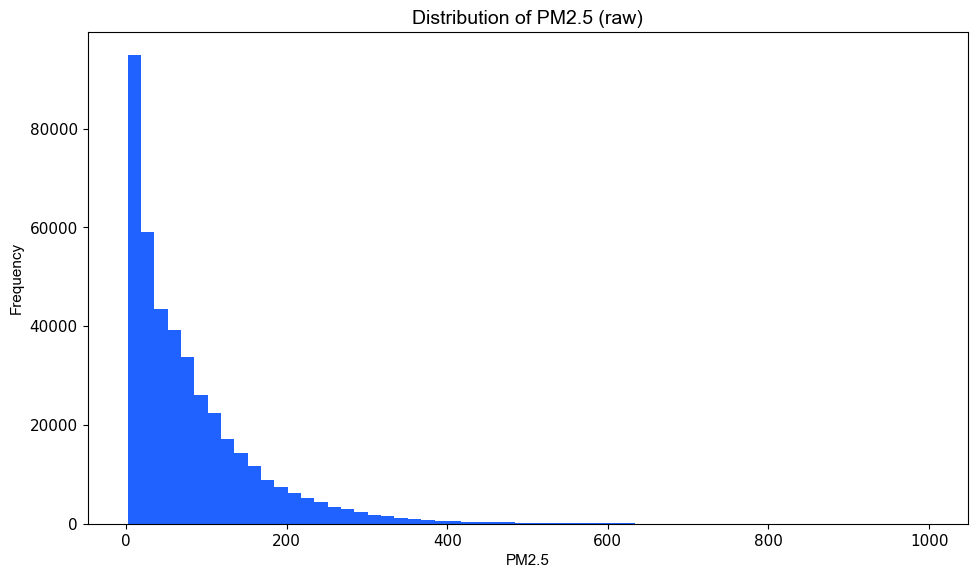

In [5]:
ds_path = (PROJECT_ROOT / OUTPUT_REG_DATASET_PATH).resolve()

print(f"ds_path: f{ds_path}")

df = pd.read_parquet(ds_path)

print(df.shape)
display(df.head())

# Lưu regression dataset sample
df.head(100).to_csv(DATA_PATH / '07_regression_dataset_sample.csv', index=False)
print('Saved:', DATA_PATH / '07_regression_dataset_sample.csv')

missing = df.isna().mean().sort_values(ascending=False).head(15)
display(missing)

# Lưu missing values
missing.to_frame(name='missing_rate').to_csv(DATA_PATH / '07_missing_values.csv')
print('Saved:', DATA_PATH / '07_missing_values.csv')

fig, ax = plt.subplots(figsize=(10, 6))
pd.Series(df[TARGET_COL]).dropna().plot(kind='hist', bins=60, ax=ax, color='#1F62FF')
ax.set_title(f'Distribution of {TARGET_COL} (raw)', fontsize=14, fontfamily='Arial')
ax.set_xlabel(TARGET_COL, fontsize=11, fontfamily='Arial')
ax.set_ylabel('Frequency', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '07_target_distribution.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '07_target_distribution.png')
plt.show()

## 3) Train/Test theo thời gian + train regressor
Lưu ý: mô hình hồi quy ở đây là **feature-based** (dùng lag + thời tiết).
Phần dự báo chuỗi thời gian *thuần* sẽ làm bằng ARIMA ở notebook kế tiếp.

Metrics:
{
  "n_train": 395301,
  "n_test": 16716,
  "rmse": 25.32672696176382,
  "mae": 12.32315830517231,
  "smape_pct": 23.837711259945237,
  "r2": 0.9491508772105639,
  "feature_cols": [
    "No",
    "year",
    "month",
    "day",
    "hour",
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "wd",
    "WSPM",
    "station",
    "hour_sin",
    "hour_cos",
    "dow",
    "is_weekend",
    "PM2.5_lag1",
    "PM10_lag1",
    "SO2_lag1",
    "NO2_lag1",
    "CO_lag1",
    "O3_lag1",
    "TEMP_lag1",
    "PRES_lag1",
    "DEWP_lag1",
    "RAIN_lag1",
    "WSPM_lag1",
    "PM2.5_lag3",
    "PM10_lag3",
    "SO2_lag3",
    "NO2_lag3",
    "CO_lag3",
    "O3_lag3",
    "TEMP_lag3",
    "PRES_lag3",
    "DEWP_lag3",
    "RAIN_lag3",
    "WSPM_lag3",
    "PM2.5_lag24",
    "PM10_lag24",
    "SO2_lag24",
    "NO2_lag24",
    "CO_lag24",
    "O3_lag24",
    "TEMP_lag24",
    "PRES_lag24",
    "DEWP_lag24",
    "RAIN_lag24",

,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,477.0,436.901040
1,2017-01-01 01:00:00,Aotizhongxin,454.0,444.198916
2,2017-01-01 02:00:00,Aotizhongxin,418.0,433.323668
3,2017-01-01 03:00:00,Aotizhongxin,438.0,371.884739
4,2017-01-01 04:00:00,Aotizhongxin,453.0,464.841039


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\07_regression_predictions.csv
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\07_actual_vs_predicted.png


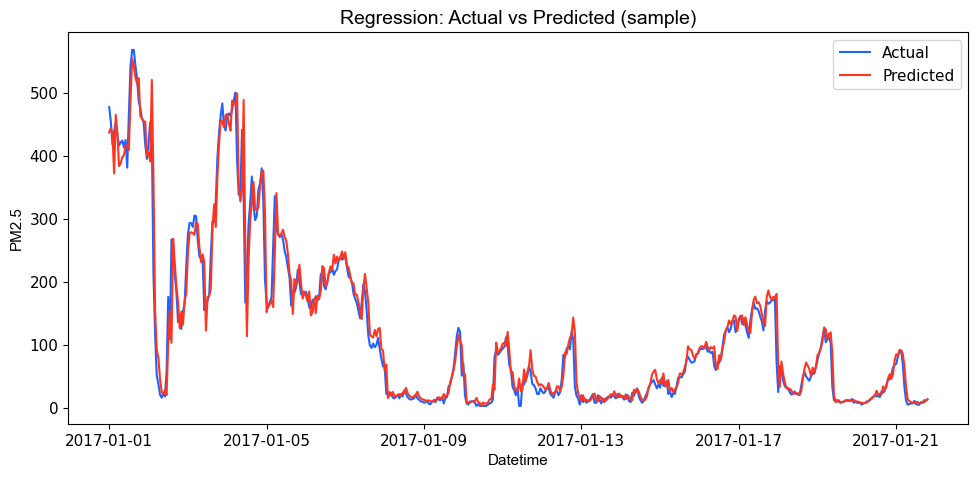

In [6]:
out = run_train_regression(
    paths=paths,
    cutoff=CUTOFF,
    model_out=MODEL_OUT,
    metrics_out=METRICS_OUT,
    preds_out=PRED_SAMPLE_OUT,
    dataset_file=OUTPUT_REG_DATASET_PATH.split("/")[-1],
)

print('Metrics:')
print(json.dumps(out['metrics'], ensure_ascii=False, indent=2))
pred_df = out['pred_df']
display(pred_df.head())

# Lưu regression predictions sample
pred_df.head(100).to_csv(DATA_PATH / '07_regression_predictions.csv', index=False)
print('Saved:', DATA_PATH / '07_regression_predictions.csv')

# Plot a small window for storytelling
sample = pred_df.dropna().iloc[:500].copy()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample['datetime'], sample['y_true'], label='Actual', color='#1F62FF')
ax.plot(sample['datetime'], sample['y_pred'], label='Predicted', color='#FF351F')
ax.set_title('Regression: Actual vs Predicted (sample)', fontsize=14, fontfamily='Arial')
ax.set_xlabel('Datetime', fontsize=11, fontfamily='Arial')
ax.set_ylabel('PM2.5', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '07_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '07_actual_vs_predicted.png')
plt.show()